Epoka 1, Strata treningowa: 10.3350, Strata walidacyjna: 1.3557, Dokładność: 60.00%
Epoka 2, Strata treningowa: 2.4674, Strata walidacyjna: 1.0427, Dokładność: 60.00%
Epoka 3, Strata treningowa: 0.7687, Strata walidacyjna: 0.6195, Dokładność: 66.67%
Epoka 4, Strata treningowa: 0.6126, Strata walidacyjna: 0.8951, Dokładność: 62.22%
Epoka 5, Strata treningowa: 0.7649, Strata walidacyjna: 0.8358, Dokładność: 51.11%
Epoka 6, Strata treningowa: 0.6754, Strata walidacyjna: 0.9132, Dokładność: 62.22%
Epoka 7, Strata treningowa: 0.5675, Strata walidacyjna: 1.3302, Dokładność: 64.44%
Epoka 8, Strata treningowa: 0.9476, Strata walidacyjna: 0.8711, Dokładność: 51.11%
Epoka 9, Strata treningowa: 0.6127, Strata walidacyjna: 0.6890, Dokładność: 68.89%
Epoka 10, Strata treningowa: 0.5600, Strata walidacyjna: 0.6685, Dokładność: 57.78%
Trening zakończony


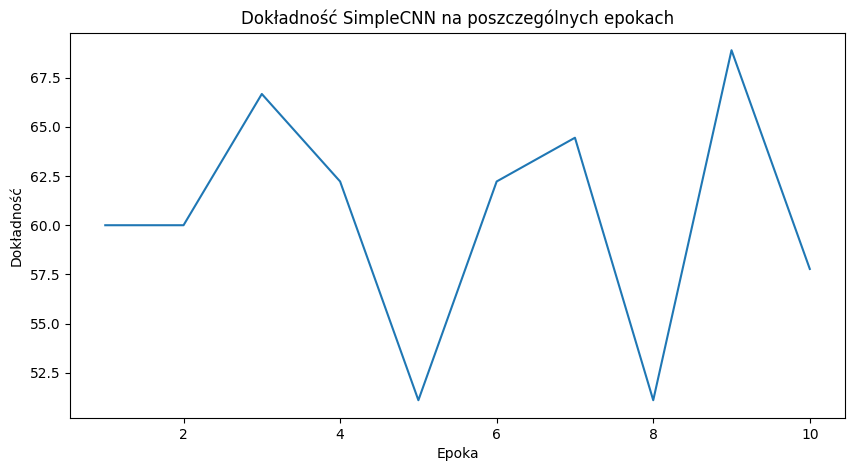

Model: ResNet
Dokładność: 43.33%
Model: AlexNet
Dokładność: 63.33%
Model: VGG
Dokładność: 53.33%
Model: SqueezeNet
Dokładność: 63.33%
Model: DenseNet
Dokładność: 63.33%
Model: SimpleCNN
Dokładność: 86.67%
[43.333333333333336, 63.333333333333336, 53.333333333333336, 63.333333333333336, 63.333333333333336, 86.66666666666667]


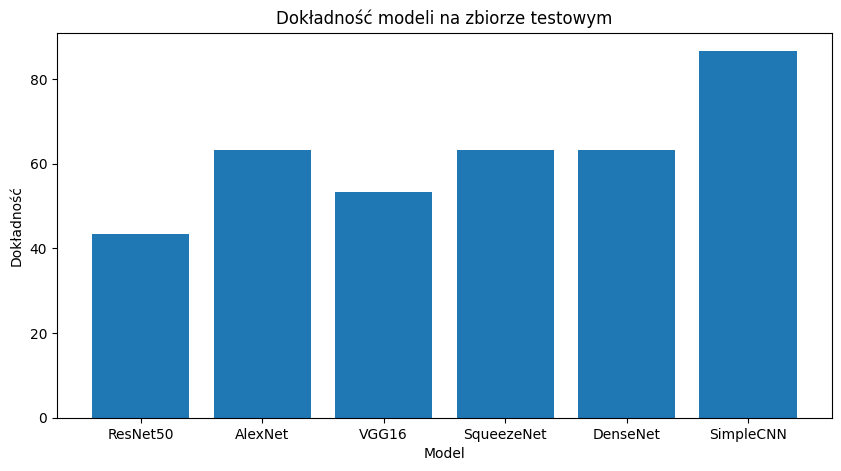

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from custom_dataset import CustomDataset
from torchvision.models import resnet50, ResNet50_Weights, alexnet, AlexNet_Weights, vgg16, VGG16_Weights, squeezenet1_0, SqueezeNet1_0_Weights, densenet161, DenseNet161_Weights
import matplotlib.pyplot as plt

#Załadowanie przetrenowanych modeli

#Model resnet50
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 1) # zmiana liczby wyjść z 1000 na 1 

# Model AlexNet
model_alexnet = alexnet(weights=AlexNet_Weights.DEFAULT)
num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, 1) 

# Model VGG16
model_vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)
num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, 1)

# Model SqueezeNet
model_squeezenet = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)
model_squeezenet.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1))
model_squeezenet.num_classes = 1

# Model DenseNet
model_densenet = densenet161(weights=DenseNet161_Weights.DEFAULT)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, 1)

# Załadowanie danych 

# Augmentacja danych dla zbioru treningowego
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformacja dla zbiorów walidacyjnego i testowego
transform = transforms.Compose([    
    transforms.Resize((256, 256)),   #obraz 256x256     
    transforms.CenterCrop(224), #wybór centralnej części obrazu o rozmiarze 224x224
    transforms.ToTensor(), #konwersja obrazu do formatu tensora             
    transforms.Normalize(              
    mean=[0.485, 0.456, 0.406],        
    std=[0.229, 0.224, 0.225] # normalizacja obrazu na podstawie średniej i odchylenia standardowego          
 )])

dataset = CustomDataset('data/obrazy', 'data/etykiety', transform=transform)

# Podział danych na treningowe i walidacyjne
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.flatten() == labels.flatten()).sum().item()
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = 100 * correct / total

    return accuracy

# Trening własnego modelu
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # druga warstwę konwolucyjną
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.dropout = nn.Dropout(0.5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Zmieniono rozmiar wejścia
        self.fc2 = nn.Linear(512, 1) 

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))  # Dodano warstwę i Batch Normalization
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Inicjalizacja modelu, funkcji straty i optymalizatora
model = SimpleCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Pętla treningowa

dokladnosc_cnn = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad() # zerowanie gradientów w celu uniknięcia ich akumulacji
        outputs = model(images) # obliczenie predykcji
        loss = criterion(outputs, labels) # obliczenie straty 
        loss.backward() # propagacja wsteczna
        optimizer.step() # aktualizacja wag
        running_loss += loss.item() # aktualizacja straty

    # Walidacja
    model.eval() 
    val_loss = 0.0
    with torch.no_grad(): 
        for images, labels in val_loader:
            outputs = model(images) 
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    # Dokładność
    accuracy = test_model(model, val_loader)
    dokladnosc_cnn.append(accuracy)
    print(f"Epoka {epoch+1}, Strata treningowa: {(running_loss / len(train_loader)):.4f}, Strata walidacyjna: {(val_loss / len(val_loader)):.4f}, Dokładność: {(accuracy):.2f}%")

print("Trening zakończony")

plt.figure(figsize=(10, 5))
plt.title("Dokładność SimpleCNN na poszczególnych epokach")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.plot(range(1, num_epochs+1), dokladnosc_cnn)
plt.show()





models_list = [model_resnet50, model_alexnet, model_vgg16, model_squeezenet, model_densenet, model]
dokladnosc = []
for model in models_list:
    accuracy = test_model(model, test_loader)
    dokladnosc.append(accuracy)
    print(f"Model: {model.__class__.__name__}")
    print(f"Dokładność: {(accuracy):.2f}%")

print(dokladnosc)

# Wykres dokładności modeli na zbiorze testowym 
plt.figure(figsize=(10, 5))
plt.title("Dokładność modeli na zbiorze testowym")
plt.xlabel("Model")
plt.ylabel("Dokładność")
plt.bar(["ResNet50", "AlexNet", "VGG16", "SqueezeNet", "DenseNet", "SimpleCNN"], dokladnosc)
plt.show()

